# Bayesball: An Analysis of Batters' Swinging Decision Using Bayesian Modelling

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 0. Setup


## Strike Zone
To start, we configure the strike zone for the batter. The strike zone has the width of the home plate, which is 17 inches (1.416 feet). The height of the strike zone depends on the batter's height and stance, and generally it is from his kneecap to the midpoint between his shoulder and belt. To standardize everything for our further calculation, we set this strike zone to 1.4ft * 2.2ft. 

We then define the coordinate system, including x,y, and z axes (unit in feet). 
- x is the horizontal direction (horizontal to the width of the homeplate)
- y is the direction from the mound to the plate
- z is the height, or vertical direction 
- we set the centre of the strike zone to (0,0,0)
- **the coordinate is at batter's perspective**  

This way, on the coordinate, the strike zone plane is at y=0, and has the range of x = -0.7 to 0.7 and z = -1.1 to 1.1 (inclusive).

In [2]:
# configure strike zone: width is x-axis, length is z-axis
# interval is 0.01ft
# on x-axis, create 30 extra spaces on each side of the strike zone border (201 spaces in total; 141 of them are in the strike zone)
# on z-axis, create 40 extra spaces on each side of the strike zone border (301 spaces in total; 221 of them are in the strike zone)
zone = np.zeros((301,201))

def is_strike(irow, icol): 
    '''note that index-row and index-col numbers are different from the cooridnate system that we set above'''
    if irow>=40 and irow<=260 and icol>=30 and icol<=170:
        return True 
    else: 
        return False

# create an array for zone border
zone_border = zone.copy()
zone_border[40:261,30] = 1
zone_border[40:261,170] = 1
zone_border[40,30:171] = 1
zone_border[260,30:171] = 1

## Pre-defined Variables & Functions

In [3]:
# some constants
pitch_dist = 60.5 # in ft (from mound to plate)
ball_diameter = 0.12 # in ft


# set plotting variables 

# create cmap of red-white spectrum 
cmap = LinearSegmentedColormap.from_list("red_white_gradient", ["white", "blue"], N=100)
# create cmap for red line strike zone border
cmap_border = mcolors.ListedColormap(['none', 'green'])

In [4]:
# functions
# calculate speed and time
def mph_to_ftpms(x): # convert mph to ft per ms 
    return x/681.8

def pitch_travel_time(x): # calculate the travel time of pitch with x mph, in ms
    return pitch_dist / mph_to_ftpms(x)


# gaussian
def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian_2d(x,y,mu_x, mu_y, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-((x-mu_x)**2+(y-mu_y)**2)/(2*sigma**2))

# gaussian with normalization
def gaus_norm(x_vec, mu, std):
    dist = gaussian(x_vec, mu, std)
    dist /= np.sum(dist)
    return dist



# convert index to coordinates
def arr_idx_to_coor(irow, icol):
    '''given row and col indices from the strike zone, return x and z coordinates in ft (z,x)'''
    center_irow = 150
    center_icol = 100
    return (((300-irow)-center_irow)*0.01, (icol-center_icol)*0.01) # output is (z,x)


# stimulus distribution
def stim_dist(mu_x, mu_z, sigma_sx, sigma_sz):
    # mu_x and mu_z are coordinates
    stim = zone.copy()
    i,j = np.indices(stim.shape)
    z,x = arr_idx_to_coor(i,j)
    stim[i,j] = gaussian(x,mu_x,sigma_sx) * gaussian(z,mu_z,sigma_sz)
    stim /= np.sum(stim)
    return stim


# likelihood dist 
def lik_dist(x_obs, z_obs, sigma):
    # x_obs and z_obs are coordinates
    lik = zone.copy()
    i,j = np.indices(lik.shape)
    z,x = arr_idx_to_coor(i,j)
    lik[i,j] = gaussian_2d(x,z,x_obs, z_obs, sigma)
    lik /= np.sum(lik)
    return lik


# posterior
def pos(prior, lik):
    pos = prior * lik
    pos /= np.sum(pos)
    return pos


# plotting 
# plot strike zone with each element being probas, along with a strike zone 
def plot_zone_map(arr, ax, vmax=1.2e-4): # arr is a 2darray
    ax.set_aspect('equal')
    sns.heatmap(arr, cmap=cmap, ax=ax, vmin=0, vmax=vmax, cbar_kws={'ticks': [], 'label': 'probability'})
    sns.heatmap(zone_border, cmap=cmap_border, ax = ax, cbar = False)
    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.set_xticks([]) 
    ax.set_yticks([]) 

# plot ball
def plot_ball(irow, icol, ax):
    # a baseball has its radius = 0.12ft
    # since the interval of our array is 0.01ft, the radius is now 12 unit on the array
    contour = Circle((icol, irow), radius=12, fill=False, edgecolor='red', linewidth=1, label='baseball')
    ax.add_patch(contour)
    ax.scatter(icol, irow, c='black', s=1, label = 'ball centre')

# plot the point w/ highest posterior proba
def plot_point(irow, icol, ax):
    ax.scatter(icol, irow, c='pink', s=100, alpha=0.7)

---

# 1. Background 
Hitting a baseball from a pitcher is not an easy task, especially for those who play at the top professional leagues like Major League Baseball (MLB). At this level, not only do most fastballs travel at 90+ mph (144+ kph), there are also different offspeed and breaking pitches, travelling with all kinds of speeds and trajectories, just to make things even more complicated. Take 2023 AL Cy Young winner Gerrit Cole as an example: his four-seam fastball has a mean velocity of 96.7 mph, and he has five different pitches in his pitch arsenal. 


In [5]:
print(f'a 96.7mph fastball takes approximately {round(pitch_travel_time(96.7),2)} ms to reach the plate')


a 96.7mph fastball takes approximately 426.57 ms to reach the plate


![Optional Alt Text](img/cole_pitch_arsenal.png)

(source: Statcast https://baseballsavant.mlb.com/savant-player/gerrit-cole-543037?stats=statcast-r-pitching-mlb)

According to what Brantley and Körding (2022) suggested in the research Bayesball, it takes ~100ms for a professional batter to observe the ball and ~150ms for him to swing at the ball. In this 96.7-mph fastball example, it only leaves the batter (427-100-150) ~177ms to decide whether to swing, and where exactly to swing at. Everything happens so fast, not to mention that pitches can vary greatly in landing spots, trajectory, and travel time. Thus batters are believed to bat with a high level of uncertainty if they try to hit a pitch solely based on their observation. 

Brantley and Körding, therefore, proposed a possible Bayesian-integration framework to explain how batters deal with such high levels of uncertainty. It is hypothesized that before each pitch, the batter has already formed some kind of belief (the prior), and by integrating with the observation (the likelihood) when he sees the incoming pitch, he can form a posterior that tells him where to swing at, to optimize his chance to hit the ball in  play. 

In the authors’s simplified model, they only took pitch height from the home plate (z-axis) as the variable of interest, without considering the horizontal location (x-axis) and the arrival time of the pitch. In this case, the prior, likelihood and posterior may be expressed as follows:

- prior: the probability of each type of pitch, and the z-distribution associated with each type of pitch
$$p(pitch)$$
$$p(z|pitch)$$
- likelihood: the batter observes the incoming pitch
$$p(z|speed)$$ 
$$p(z|spin)$$
$$p(z|movement)$$
- posterior: infer the z-distribution of this pitch, with an associated launch angle 
$$p(z, launchAngle)


Some extreme examples were given in the paper:
1. In a situation of pitch tipping where the pitcher shows different set-up positions for different pitches (e.g. fastball vs. curveball), the batter can form a narrow prior since he now gets a higher certainty of the incoming pitch associated with that set-up position. 
2. If the pitcher is known for throwing Knuckleballs, which has highly unpredictable movements, the prior is now weak. While the likelihood tends to be weaker due to the uncertain movement, it is still more reliable than the prior. The batter therefore tries to hit the ball relying more on his likelihood.
3. If the pitcher happens to throw an Eephus, which is another uncommon pitch characterized by very slow speed and parabola-like trajectory. Since it is uncommon, the prior is weak too, but with its slow speed, the batter can develop a relatively stronger likelihood. The batter now tries to bat this pitch with reliance on his likelihood.
  
HOWEVER, these three examples are pretty uncommon in any professional game. (Justify it), and the applicability of this paper to real-world scenarios may be limited. Therefore, in this project, I will try to elucidate how a batter become able to hit a ball from the basis, using Bayesian Integration. Specifically, I will explore the following conditions: 
- Fastball only 
- Fastball only, but now with a surprise pitch 
- Adding different pitches to increase the uncertainties 
And discuss the batting strategy along the line.

---

# 2. Novel Experimental Test of Model 

In the section Theoretical Analysis, I will run some simulation purely based on computations. However, the real-world scenarios have significantly more variables, and will need different technologies and equipments to collect data. The simulation, as a result, will depend on several assumptions and simplifications. But here in this section, I will propose an ideal in-lab experiment that can possibly record our data of interest, and how we want to process these data. 

## (Ideal) Experiment Set-up 
We will run trials in an appropriate batting cage that is equipped with a pitching mound, and we will recruit some batters with a certain level of game experience. A fine-calibrated pitching machine is used to simulate a right-handed pitcher, that we can use it to throw a certain type(s) of pitch at spots that we want. Specifically, we specify the centre point (x,z) on the strike zone plane, along with x-variability and z-variability, and the machine pitches the balls with that exact distribution. Also, we can actually know this distribution from the machine (i.e. we have access to the heat map (colour indicating probability)). For each batter, there are (3) trials to run, each contains a set amount of at-bats. Before each trial, the batter will study the heat map of the pitching machine (to construct his prior), and know what type(s) of pitch the machine is going to throw at him. 

We will also need to construct a 3D digital model that reflects our batting cage, as well as every pitch and swing in the computer. In the model, a static coordinate is set up. We will then need to record the pitch flight trajectory and the bat swinging trajectory. To achieve this, some possible technologies / equipment may be used: 
- Rapsodo pitch tracking machine 
- HitTrax hit tracking machine 
- High-speed cameras 
- Radars 
- Or even something that is injected in the ball/bat that can track its movement in space, and can translate the data into our digital model 
  
The point is that by recording the movement trajectory data of the ball and the swing trajectory of the bat, we can then better calculate the probabilities of a batter trying to hit a ball at a certain timestamp, and the utility of that hit (combining exit velocity and launch angle), or, adversely, the probability of swinging and missing that pitch.

Theoretically, by plugging in the prior that the batter studies before a trial, we can explore his likelihood uncertainties, motor noise, utility functions, etc. This is expected to give us insights when we want to further help the batter improve in certain batting aspects, by simply analyzing the numbers and models.

## In-lab Experiment: Trial 1
In this trial, the batter will face only fastballs. The machine will pitch at one of the strike zone corners, with some x- and z-variabilities. For example, for a left-handed hitter, we may set the pitch to around the top of the zone, away from him (the top left corner from his perspective). This pitch distribution / heatmap will be given to the batter for him to construct his prior. The machine will pitch according to the heatmap. 
However, in the last 5 pitches, we want the machine to have some variations. In these 5 pitches, the 1st, 3rd and 5th will be set to ‘not following the prior’. In other words, the batter will have some ‘surprise pitch’ that contradict the heatmap he studied. He is expected to have a lower chance of hitting those pitches. 

## In-lab Experiment: Trial 2
In this trial, the batter needs to hit a certain kind of breaking/offspeed pitch other than fastball (e.g. splitters with vertical variability that land at the bottom of the zone, or sweepers with more horizontal variability that land inside of the zone). It is, still, only one type of pitch, but not fastball. In this part, the batter will study the heatmap of this certain pitch once again before the trial. we will also introduce the last five pitches, just like Trial 1 (with still the same pitch type in Trial 2). We will study how the batter adapts to a different pitch type, how their performance is affected, and whether their likelihood becomes more vague. 

## In-lab Experiment: Trial 3
 The last trial will consist of both fastball and the type of breaking/offspeed pitch used in Trial 2. The batter knows what the two types of pitches are being used, but he would not know what exactly he will be throwing at for each at-bat. He is also asked to study the combined heatmap / prior that comes from the first two trials. Since the two types of pitches are expected to land at very different spots, the prior will be diluted when combined, and the batter should be more uncertain. If the batter is more uncertain in his prior, he is expected to rely more on his likelihood when batting (just like the knuckle ball case in the research Bayesball). 

## To Visualize what is going on
In reality, so many parameters and variables need to be considered; if we want to build a 'realistic' model, the most straightforward way is to build a 4D model (x,y,z as space, plus t as timeline), detailing in every movement of the ball, the batter, and his swing. From there, theoretically, we can calculate probabilities of the batter hitting the ball (and maybe the utility as well: launch angle and exit velocity), at every timepoint for every coordinate (x,y,z,t). This is expected to require a lot of math, physics, and computation (it is just like SpaceX trying to optimize the launch of their rockets--it takes a good chunck of time!).

But before that, we can certainly do something else. We will simulate the experiment, and that can be done even before physically running the lab! Of course, it needs some simplification. We will address further assumptions and simplifications in part 3, but here we will visualize how the three trials may look like. 

### Pitching Machine / Stimulus Distribution
The pitching machine will mimic a pitcher by shooting balls from a certain height; in other words, it creates the stimulus for the batter, following a certain stimulus distribution. We assume that this machine is finely calibrated: it aims at a certain point on the strike-zone plane (y=0) (the centre $(\mu_x,\mu_z$), with independent x-variability $\sigma_{s,x}$ and z-variability $\sigma_{s,z}$. So each time it pitches a ball, when reaching y=0, the ball will land at (x=a, z=b) with probabilities
$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^\frac{-((x-\mu_x)^2}{2\sigma^2}$$
times
$$f(z) = \frac{1}{\sqrt{2\pi\sigma^2}}e^\frac{-((z-\mu_z)^2}{2\sigma^2}$$
. With different $\sigma_{s,x}$ and $\sigma_{s,z}$, the stimulus distribution will be 2 dimensional with some different oval-like shapes. 
  
Below is the visualization of a simulation, with following data:
- Fastball: 
    - with speed = 96mph and spin = 2400rpm; throw in a way that the trajectory looks almost 100% straight. Assume that movements of other direction (including extra drop caused by gravity) is negligible.
    - centres at $(\mu_{FF,x},\mu_{FF,z})=(-0.5,0.8)$ (aim at top left)
    - with x-variability $\sigma_{FF,x} = 0.3$ and z-variability $\sigma_{FF,z}=0.4$.
- Splitters (the selected breaking ball type for trial 2): 
    - with speed = 88mph and spin = 1300rpm; throw in a way that it mimics the fastball trajectory at first, but will drop sharply when approaching the plate
    - centers at $(\mu_{FS,x},\mu_{FS,z})=(0,-0.6)$ (aim at bottom centre)
    - with x-variability $\sigma_{FS,x}=0.3$ and z-variability $\sigma_{FS,z}=0.5$. 
- In trial 3, throws 50% fastballs and 50% splitters (always 50%/50% everytime the batter is at bat, so he kind of needs to make a guess).

### The Batter
Some assumptions about the batter: 
- He is left-handed. To him, the fastballs are going to land on his outside (he stands at the right side of the zone). Also, this makes that in trial three, the fastballs and the splitters will have some level of tunnel effect (i.e. they share similar flight trajectories at first) since we make our pitching machine mimicing a right-handed pitcher.
- He has experience facing pitches similar to what we simulate, and has ability to make contact with the ball.

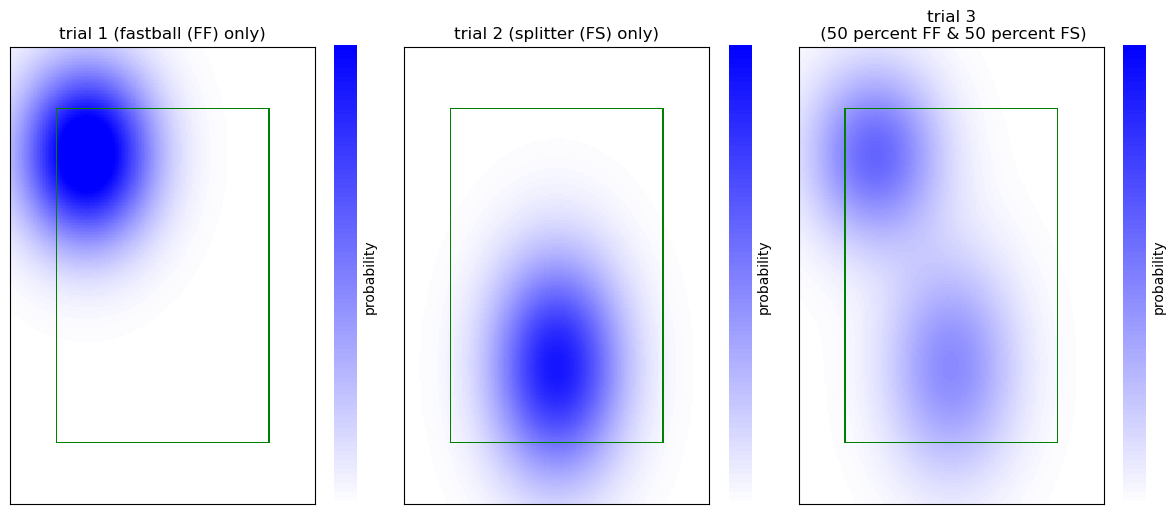

In [6]:
# stimulus distribution from the pitcher
# only depict the strike zone plane with x and z dimension
# for now, not considering...
# ... y direction (the direction from mound to plate)
# ... speed and spin either

# for fastball
mu_ffx = -0.5
mu_ffz = 0.8
sigma_ffx = 0.3
sigma_ffz = 0.4
ff = stim_dist(mu_ffx, mu_ffz, sigma_ffx, sigma_ffz)

# for splitter
mu_fsx = 0
mu_fsz = -0.6
sigma_fsx = 0.3
sigma_fsz = 0.5
fs = stim_dist(mu_fsx, mu_fsz, sigma_fsx, sigma_fsz)

# combined 
combined = 0.5*ff+0.5*fs

# plots 
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,5))
plot_zone_map(ff,ax1)
plot_zone_map(fs,ax2)
plot_zone_map(combined, ax3)
ax1.set_title('trial 1 (fastball (FF) only)')
ax2.set_title('trial 2 (splitter (FS) only)')
ax3.set_title('trial 3\n (50 percent FF & 50 percent FS)')
plt.tight_layout()
plt.show()


As shown in figure 1 and 2, the probability radiates outward from the centre that the machine aims at. For figure 3, since it combines the two distribution, the color fades, meaning that everything becomes less certain.

---

# 3. Theoretical Analysis 
## 3.1 Step 1: Generative Model (also see the plots above)
In the section above, we have simulated three trials with a heatmap/stimulus distribution of each trial, generated by the fine-tuned pitching machine. We will continue from there. Specifically, we will start by focusing on and discussing the fastball-only trial.

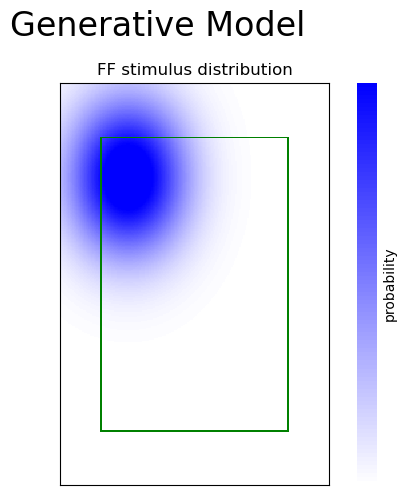

In [7]:
# generative model / stimulus distribution of trial 1 (fastball only)
# same thing as 'trial 1' in the plot above
fig, (ax1) = plt.subplots(1,1,figsize=(6,5))
plot_zone_map(ff,ax1)
ax1.set_title('FF stimulus distribution')
fig.suptitle('Generative Model', fontsize = 24)
plt.tight_layout()
plt.show()


## 3.2 Step 2: Inference 
### Prior
As designed, the batter is asked to study the heatmap (pitch distribution/stimulus distribution) before the experiment start. If he studies extensively and happens to picture that perfectly in mind, this stimulus distribution becomes his prior. In real world, prior to a game, a professional batter tends to study the pitcher's statistics, including the pitch distribution of each pitch type. You don't want to step up onto the plate without knowing anything from the pitcher. So in the case of baseball, it is common to have some sort of prior instead of just a flat prior. For the simulation, we will simulate the conditions of both 
- with a flat prior, and 
- with a perfect prior (same as the stimulus distribution)  

, to help us understand what is going on.

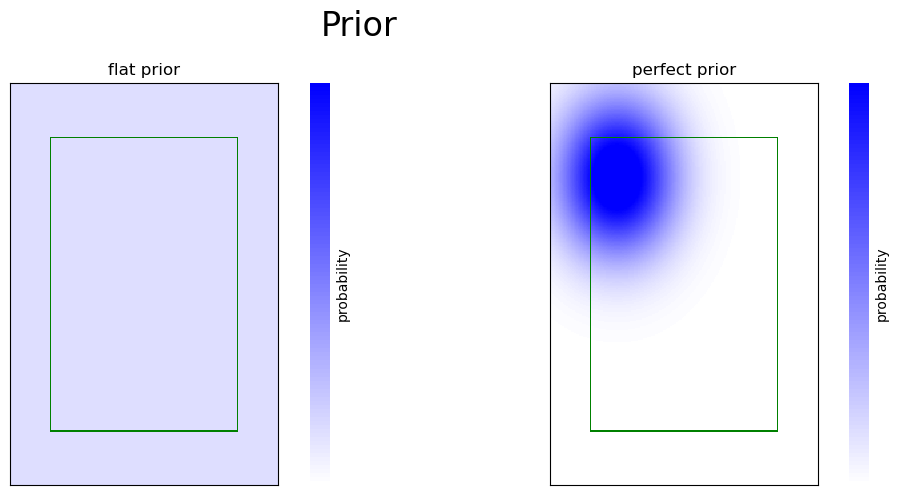

In [8]:
# prior 
# flat prior; 100% inside the grid (strike zone + out of strike zone, 
# the range is limited to what we defined when we first constructed the strike zone) 
prior_flat = zone.copy()
prior_flat[:,:] = 1
prior_flat /= np.sum(prior_flat)


# perfect stimulus prior; just like the stimulus distribution from the pitcher 
prior_stim = ff.copy()

# plots 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
plot_zone_map(prior_flat,ax1)
plot_zone_map(prior_stim,ax2)
ax1.set_title('flat prior')
ax2.set_title('perfect prior')
fig.suptitle('Prior', fontsize = 24)
plt.tight_layout()
plt.show()

### Generate one specific stimulus
Now, we generate one single pitch by randomly drawing from the stimulus distribution.


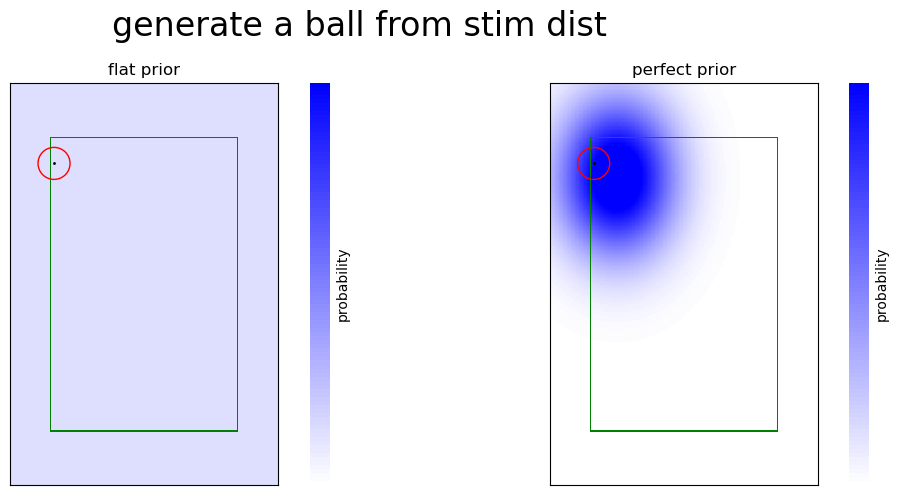

this fastball is located at x=-0.67 and z=0.9


In [9]:
#randomly draw a ball from the stimulus distribution 
np.random.seed(42)
flat_proba = ff.flatten()
ff1 = np.random.choice(len(flat_proba), p=flat_proba)
ff1_irow, ff1_icol = np.unravel_index(ff1, ff.shape)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
plot_zone_map(prior_flat,ax1)
plot_zone_map(prior_stim,ax2)
ax1.set_title('flat prior')
ax2.set_title('perfect prior')
plot_ball(ff1_irow,ff1_icol, ax1)
plot_ball(ff1_irow,ff1_icol, ax2)
fig.suptitle('generate a ball from stim dist', fontsize = 24)

plt.tight_layout()
plt.show()

ff1_z, ff1_x = arr_idx_to_coor(ff1_irow, ff1_icol)
print(f'this fastball is located at x={ff1_x} and z={ff1_z}')

### Likelihood
Now we will explore the batter's uncertainty when observing a ball. As discussed, the batter must finish his observation and start swinging (if he thinks he can hit the ball) before the ball lands on the strike zone. In other words, when he observes the ball, the ball is still in flight. This is hardly able for us to calculate the probabilities on a 2D plane. So, let's make some simplification and only explore the problem on the strike zone plane.
  
We will think in another way around. Let's assume that: the batter forms a likelihood heatmap **on the strike zone plane**, that is, when he observes a ball that is still in flight, he can map out the likelihood probability matrix of where that ball is going to land on the strike zone plane. In the matrix, each point is a point on the strike zone plane, with a value being the probability of how probable the ball will land on that point. This probability density matrix centres at the batter's observation $(x_{obs},z_{obs}$, with an uncertainty parameter $\sigma$ that radiates outward from the centre. 
  
One thing is that instead of using the typical gaussian function to figure out the likelihood on a 1D straight line, we now is working on a 2D plane. A way to think about this is: in the Gaussian function, there is a term $(x-\mu)*2$, stating the **squared distance** of x from $\mu$. We see that the probability density is related to the squared distance of one point from the centre point. On a 2D plane, the distance is $\sqrt{(x-\mu_x)^2 + (y-\mu_y)^2}$, and the squared distance is simply taking off the square root.
  
So, the function can be written as 
$$f(x,y) = \frac{1}{\sqrt{2\pi\sigma^2}}e^\frac{-((x-\mu_x)^2 + (y-\mu_y)^2)}{2\sigma^2}$$
In our specific case, for point (x,z), it becomes 
$$f(x,z) = \frac{1}{\sqrt{2\pi\sigma^2}}e^\frac{-((x-x_{obs})^2 + (z-z_{obs})^2)}{2\sigma^2}$$

For our simulation visualization, let's just assume this batter forms his likelihood function with the following parameters:
- centres (x_{obs},z_{obs})$ at the exact location that the ball will land (ff1_x,ff1_z)
- with uncertainty $\sigma = 0.5$

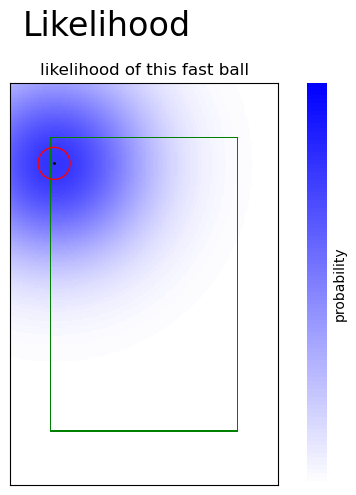

In [10]:
# likelihood 
sigma = 0.5
x_obs = ff1_x
z_obs = ff1_z
lik_ff1 = lik_dist(x_obs,z_obs,sigma)
fig, ax = plt.subplots(1,1,figsize=(6,5))
plot_zone_map(lik_ff1,ax)
plot_ball(ff1_irow,ff1_icol, ax)
ax.set_title('likelihood of this fast ball')
fig.suptitle('Likelihood', fontsize = 24)
plt.tight_layout()
plt.show()


### Posterior 
Posterior can be found simply by multiplying the prior probability matrix and the likelihood probability matrix, and then normalizing it. 
- MLE (maximum likelihood estimation): since a flat prior is uninformative, the posterior estimation can soly rely on observation, or likelihood. This case, the posterior is equal to the likelihood, and the maximal posterior is the MLE.
- MAP (maximal a posteriori): find the highest posterior probability by combining an informative prior and the likelihood.

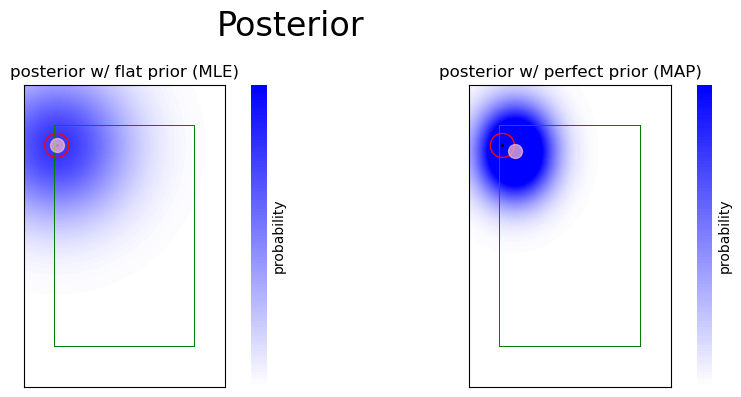

In [11]:
# posterior
# for flat prior
pos_flat = prior_flat * lik_ff1 
pos_flat /= np.sum(pos_flat)
pos_flat_icol, pos_flat_irow = np.unravel_index(np.argmax(pos_flat), pos_flat.shape)

# perfect stimulus prior
pos_stim = prior_stim * lik_ff1 
pos_stim /= np.sum(pos_stim)
pos_stim_icol, pos_stim_irow = np.unravel_index(np.argmax(pos_stim), pos_stim.shape)

# plots 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
plot_zone_map(pos_flat,ax1)
plot_zone_map(pos_stim,ax2)
plot_ball(ff1_irow,ff1_icol, ax1)
plot_ball(ff1_irow,ff1_icol, ax2)
plot_point(pos_flat_icol, pos_flat_irow, ax1) # MLE
plot_point(pos_stim_icol, pos_stim_irow, ax2) # MAP

ax1.set_title('posterior w/ flat prior (MLE)')
ax2.set_title('posterior w/ perfect prior (MAP)')
fig.suptitle('Posterior', fontsize = 24)

plt.tight_layout()
plt.show()

In the plots above, the pink circles are the points that the batter has the highst chance predicting where the ball will land. Since we assume that the batter's measurement centre = where the ball will land exactly, so the MLE (posterior formed by likelihood, since the prior is not informative) has no bias, but higher uncertainty. On the other hand, the MAP (affected by the prior, in this case, the stimulus distribution) has a little bias, but less uncertainty.

### Case: A Surprise Pitch
What if the pitching machine throws a surprise pitch that is outside of its stimulus distribution / batter's prior? Let's simulate a pitch at the very centre (0,0) of the strike zone.  

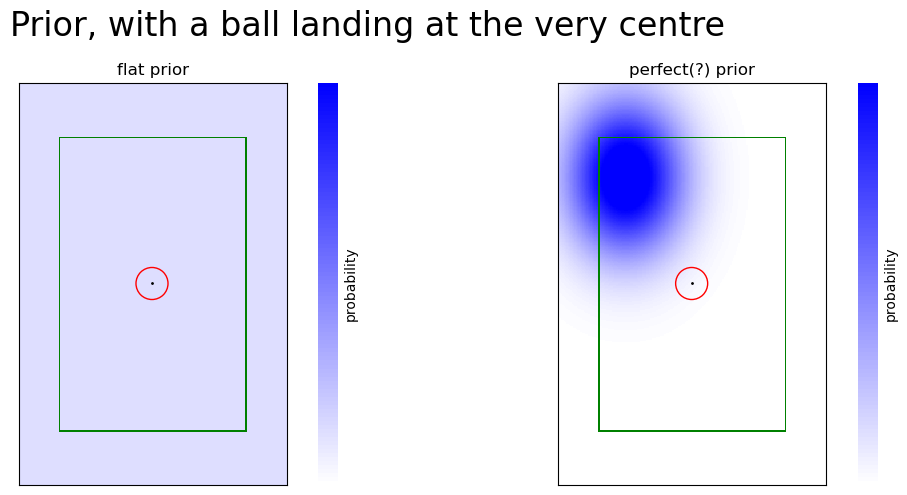

this fastball is located at x=0.0 and z=0.0


In [12]:
# prior distribution with pitched ball at dead centre 

ff2_irow, ff2_icol = 150,100 # indices for ball at x=0,z=0
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
plot_zone_map(prior_flat,ax1)
plot_zone_map(prior_stim,ax2)
ax1.set_title('flat prior')
ax2.set_title('perfect(?) prior')
plot_ball(ff2_irow,ff2_icol, ax1)
plot_ball(ff2_irow,ff2_icol, ax2)
fig.suptitle('Prior, with a ball landing at the very centre', fontsize = 24)
plt.tight_layout()
plt.show()

ff2_z, ff2_x = arr_idx_to_coor(ff2_irow, ff2_icol)
print(f'this fastball is located at x={ff2_x} and z={ff2_z}')

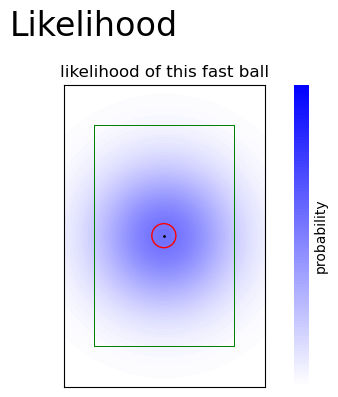

In [13]:
# likelihood 
x_obs = ff2_x
z_obs = ff2_z
lik_ff2 = lik_dist(x_obs,z_obs,sigma)
fig, ax = plt.subplots(1,1,figsize=(6,4))
plot_zone_map(lik_ff2,ax)
plot_ball(ff2_irow,ff2_icol, ax)
ax.set_title('likelihood of this fast ball')
fig.suptitle('Likelihood', fontsize = 24)
plt.tight_layout()
plt.show()

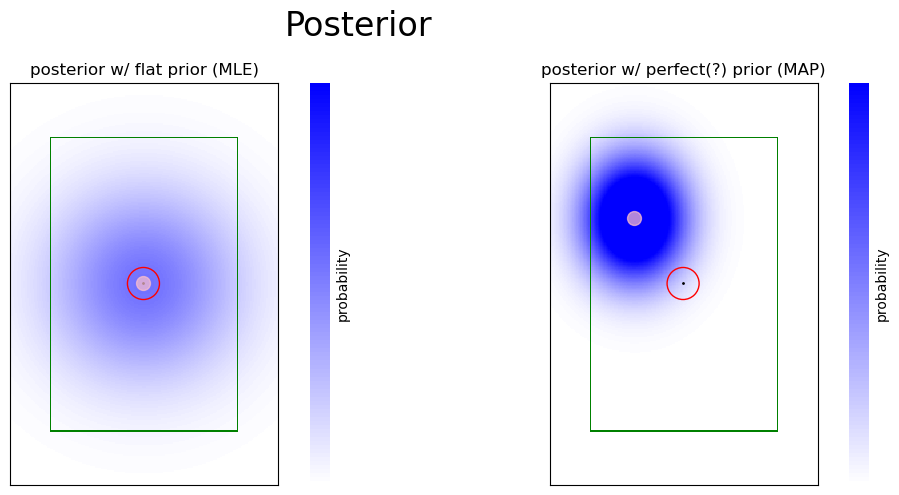

In [14]:
# posterior
# for flat prior
pos_flat_ff2 = prior_flat * lik_ff2
pos_flat_ff2 /= np.sum(pos_flat_ff2)
pos_flat_icol_ff2, pos_flat_irow_ff2 = np.unravel_index(np.argmax(pos_flat_ff2), pos_flat_ff2.shape)

# perfect stimulus prior
pos_stim_ff2 = prior_stim * lik_ff2
pos_stim_ff2 /= np.sum(pos_stim_ff2)
pos_stim_icol_ff2, pos_stim_irow_ff2 = np.unravel_index(np.argmax(pos_stim_ff2), pos_stim_ff2.shape)

# plots 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
plot_zone_map(pos_flat_ff2,ax1)
plot_zone_map(pos_stim_ff2,ax2)
plot_ball(ff2_irow,ff2_icol, ax1)
plot_ball(ff2_irow,ff2_icol, ax2)
plot_point(pos_flat_icol_ff2, pos_flat_irow_ff2, ax1) # MLE
plot_point(pos_stim_icol_ff2, pos_stim_irow_ff2, ax2) # MAP

ax1.set_title('posterior w/ flat prior (MLE)')
ax2.set_title('posterior w/ perfect(?) prior (MAP)')
fig.suptitle('Posterior', fontsize = 24)
plt.tight_layout()
plt.show()

*Note: the color looks lighter when compared to the first case (the ball lands at top left corner). Since our 'zone' is defined to be finite, that the spaces outside of the boundary will not be calculated. This affects the probabilities when we normalize it, so the rendered color saturation looks different. But in real world, the probability distribution should look the same.*   

In this case, with MLE the batter still has its posterior centre on the ball, but the uncertainty is still high. 
  
With MAP, however, the batter can totally miss the ball. This is because the batter has a wrongful prior. The peak of the prior happens to have a large distance from the likelihood centre, or where the ball lands, causing an incorrect integration. In this case, even if the batter has higher certainty compared to MLE, his estimation will be super wrongful. 

## 3.3 Resposne Distribution
The response of a batter is simply he swinging and trying to hit the ball. However, this will be hard to derive: 
- Instead of a single point, the ball and the bat have volume. The ball is a spherical shape, and the bat's barrel part is a cylindar shape. 
- The bat is the main problem here. We may use a rectangle to express the cross-section of the bat. But the problem is: **The batter is not swinging the bat horizontally to the ground**. The rectangle must be rotated to some angle that conforms to the angle that the batter is swinging at. 
- Even though we use this rotated rectangle to calculate the probabilities all over the entire strike zone plane, **there is so many more probabilities that the batter can hit the ball on the other planes (y≠0)**. You see, the batter's swing is (in some way) perpendicular to the strike zone plane, and he does not necessarily need to hit the ball right on the plane. To calculate and approximate the real probability, we must use a 3-dimensional space to calculate, and this is also the reason why our ideal experiment needs to build a 3D virtual model on the computer and tries to collect data including the movement of the batter's bat.
  
All in all, we will skip the response distribution part, but the idea is: having a 3D space set up in the computer -> simulate the ball trajectory and the swing trajectory, with some level of uncertanties (just like what we did above) -> multiply the probability matrices and derive the probability of hitting the ball -> using physics, calculate the exit velocity and the launch angle for the utility function.


# 3.4 simulation of trial 3
Similarly, trial 2 may be simulated using the same process as trial 1, although the measurement uncertainty $\sigma$ can be different since the breaking ball movement will be harder to predict compared to fastball. We will skip trial 2 for now, and discuss trial 3: essentially, how would a batter swing when there is more than one pitch type?
  
Now we simulate one case from trial 3: the batter studies the stimulus distribution of 50% fastball and 50% splitter combined, as shown in Section 2. We assume that in terms of pitch trajectory, the fastball and the splitter shares the similar trajectory at first, but then the splitter will sharply drop when approaching the home plate. For the batter, these two pitches create the **tunneling effect** i.e. they come out from the same 'tunnel'; in the tunne, they travel the same way, but after coming out of the tunnel, they diverge. 

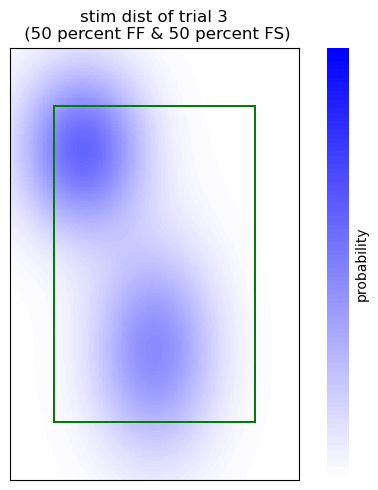

In [15]:
fig, (ax3) = plt.subplots(1,1,figsize=(6,5))
plot_zone_map(combined, ax3)
ax3.set_title('stim dist of trial 3\n (50 percent FF & 50 percent FS)')
plt.tight_layout()
plt.show()

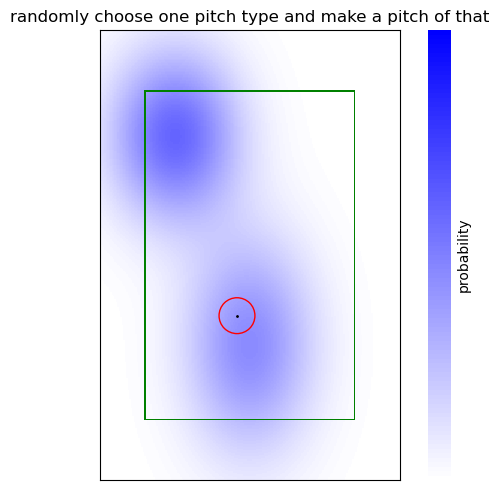

splitter


In [16]:
#randomly draw a ball from either FF or FS, then the stimulus distribution 
def trial_3(): 
    # randomly choose a pitch type and then draw a ball from the dist of that type 
    idx = np.random.choice([0,1])
    p_type = [ff,fs][idx]
    if idx == 0: 
        name = 'fastball'
    else: 
        name = 'splitter'
    flat_proba = p_type.flatten()
    p = np.random.choice(len(flat_proba), p=flat_proba)
    irow,icol = np.unravel_index(p, p_type.shape)
    return {'pitch_type':name, 'irow':irow, 'icol':icol}

np.random.seed(120)
t3p_irow, t3p_icol = trial_3()['irow'], trial_3()['icol']
fig, (ax3) = plt.subplots(1,1,figsize=(6,5))
plot_zone_map(combined, ax3)
plot_ball(t3p_irow, t3p_icol, ax3)
ax3.set_title('randomly choose one pitch type and make a pitch of that')
plt.tight_layout()
plt.show()


print(trial_3()['pitch_type'])

When the batter observes this splitter, the pitch is still in the midway of its flight. Due to the tunneling effect, it travels just like a fastball. It hasn't shown any sudden drop because it is not close enough to the plate. Now, he thinks he observes a fastball, possibly landing at (x=-0.3,z=0.6), but with even greater uncertainty (sigma = 1)

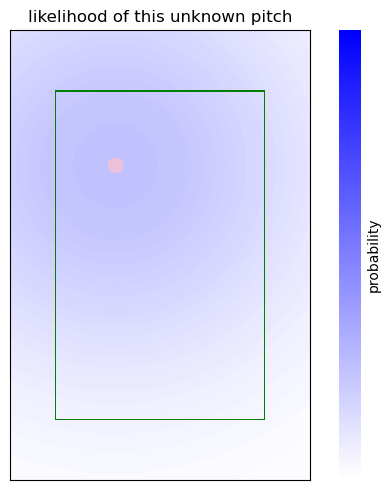

In [17]:
# likelihood 
sigma_t3 = 1
x_obs_t3 = -0.3
z_obs_t3 = 0.6
lik_t3 = lik_dist(x_obs_t3,z_obs_t3,sigma_t3)
x_obs_t3_irow, z_obs_t3_icol = np.unravel_index(np.argmax(lik_t3), lik_t3.shape)

fig, ax = plt.subplots(1,1,figsize=(6,5))
plot_zone_map(lik_t3,ax)
plot_point(x_obs_t3_irow, z_obs_t3_icol, ax) 
ax.set_title('likelihood of this unknown pitch')
plt.tight_layout()
plt.show()

If the batter integrates this likelihood with the stimulus distribution as his prior, it will look like this:

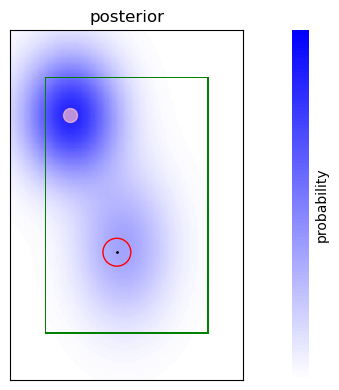

In [18]:
# posterior
# for flat prior
prior_t3 = combined
pos_t3 = prior_t3 * lik_t3
pos_t3 /= np.sum(pos_t3)
pos_t3_irow, pos_t3_icol = np.unravel_index(np.argmax(pos_t3), pos_t3.shape)

# plots 
fig, (ax1) = plt.subplots(1,1,figsize=(10,4))
plot_zone_map(pos_t3,ax1)
plot_ball(t3p_irow, t3p_icol, ax1)
plot_point(pos_t3_irow, pos_t3_icol, ax1) # MAP

ax1.set_title('posterior')

plt.tight_layout()
plt.show()

It shows that if guessing the wrong pitch, it leads to an erroneous posterior that misleads his swing. So how can a batter do when facing this type of situation? 
## Inferring the pitch type before integration 
A possible way to deal with it is to **try to figure out the pitch type**. For example, a batter may try to infer the possible speed, spin, movement, etc. of a pitch when it comes out from the pitcher's hand, combine with the prior knowledge, to decide which type of pitch has the highest probability this pitch is. In other words, he uses Bayesian integration (to figure out the pitch type) in another Bayesian integration (to figure out where the pitch may land)!

Again, the profiles of the pitches:
- Fastball: 96mph, 2400rpm, approximately straight movement 
- Splitter: 88mph, 1300rpm, approximately straight movement at first, but when approaching the plate, it will sharply drop

### Batter's prior for fastball and splitter
Let's say the batter believes that a fastball will have the following information:
- speed: mean = 96, std = 3
- spin: mean = 2400, std = 200
- displacement right before swinging (approximately 200ms before the ball reaches the plate): mean = 0.3, std = 0.1  

and for a splitter: 
- speed: mean = 88, std = 4
- spin: mean = 1300, std = 300
- displacement right before swinging: mean = 0.5, std = 0.3

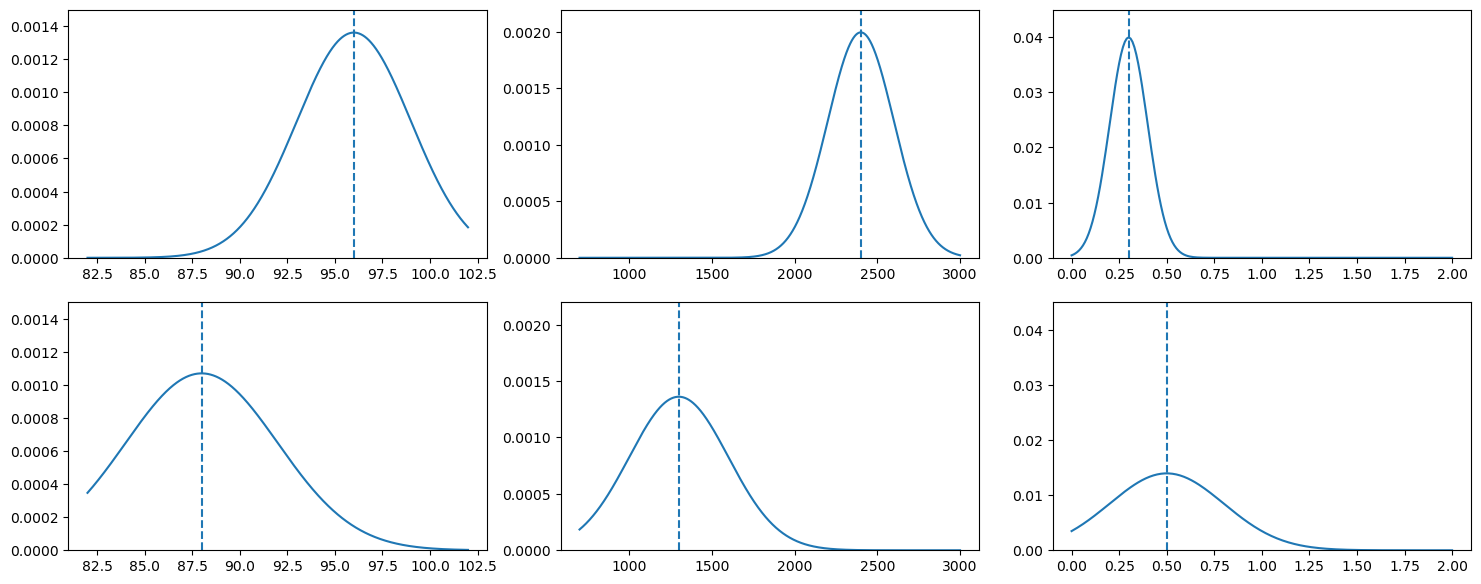

In [19]:
# prior 
fig, ([ax1,ax2,ax3],[ax4,ax5,ax6]) = plt.subplots(2,3,figsize = (15,6))

v_vec = np.linspace(82,102,2001)
spin_vec = np.linspace(700,3000,2301)
disp_vec = np.linspace(0,2,201) # displacement when observed at t=-250ms

# ff
ff_v = gaus_norm(v_vec, 96,3)
ff_spin = gaus_norm(spin_vec,2400,200)
ff_disp = gaus_norm(disp_vec,0.3,0.1)


# fs
fs_v = gaus_norm(v_vec, 88,4)
fs_spin = gaus_norm(spin_vec,1300,300)
fs_disp = gaus_norm(disp_vec,0.5,0.3)


# plot ff
ax1.plot(v_vec,ff_v)
ax1.axvline(96,linestyle='--')
ax2.plot(spin_vec, ff_spin)
ax2.axvline(2400,linestyle='--')
ax3.plot(disp_vec, ff_disp)
ax3.axvline(0.3,linestyle='--')

# plot fs
ax4.plot(v_vec,fs_v)
ax4.axvline(88,linestyle='--')
ax5.plot(spin_vec, fs_spin)
ax5.axvline(1300,linestyle='--')
ax6.plot(disp_vec, fs_disp)
ax6.axvline(0.5,linestyle='--')

# set lim
ax1.set_ylim([0,0.0015])
ax4.set_ylim([0,0.0015])
ax2.set_ylim([0,0.0022])
ax5.set_ylim([0,0.0022])
ax3.set_ylim([0,0.045])
ax6.set_ylim([0,0.045])


plt.tight_layout()
plt.show()

## Likelihood
When a batter sees an incoming pitch, his measurement of this pitch is:
- speed: mean = 90, std = 7
- spin: mean = 1700, std = 800
- displacement right before swinging: mean = 0.4, std = 0.4

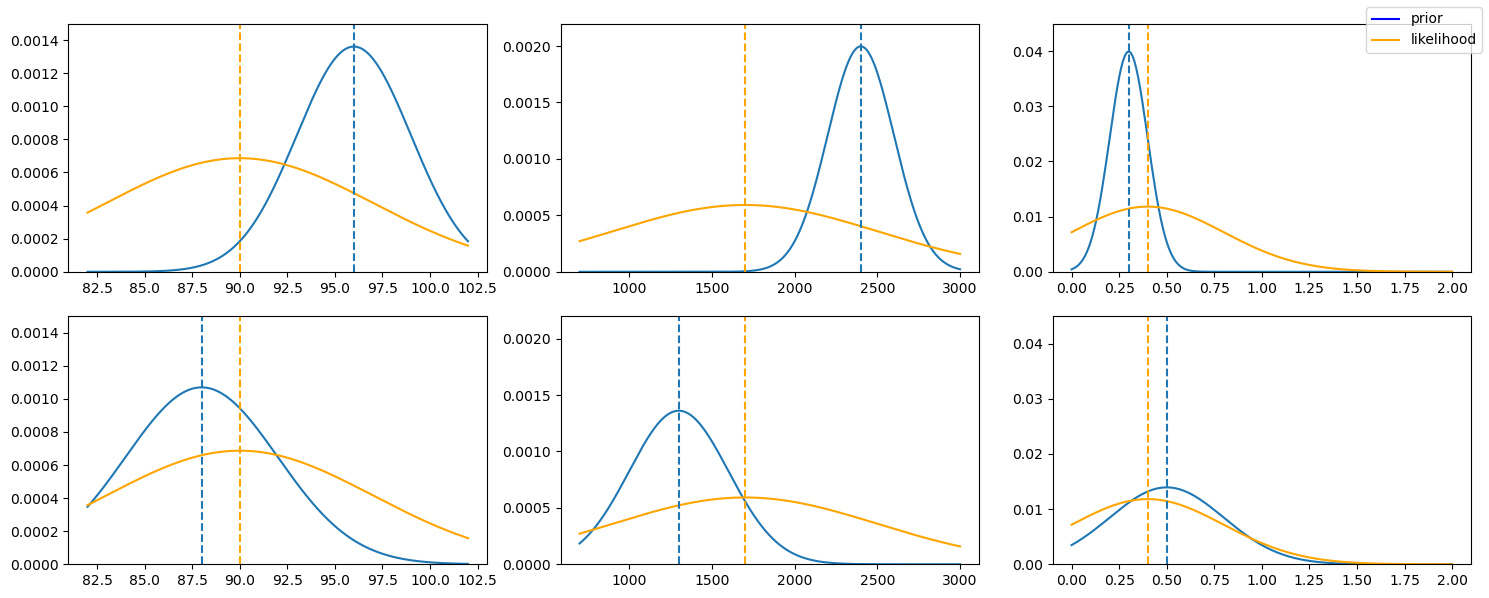

In [20]:
# likelihood 
v = gaus_norm(v_vec,90,7)
spin = gaus_norm(spin_vec,1700,800)
disp = gaus_norm(disp_vec,0.4,0.4)


# posterior 
ff_v_pos = pos(ff_v,v)
ff_spin_pos = pos(ff_spin,spin)
ff_disp_pos = pos(ff_disp,disp)
fs_v_pos = pos(fs_v,v)
fs_spin_pos = pos(fs_spin,spin)
fs_disp_pos = pos(fs_disp,disp)


fig, ([ax1,ax2,ax3],[ax4,ax5,ax6]) = plt.subplots(2,3,figsize = (15,6))

# original prior plot
# plot ff
ax1.plot(v_vec,ff_v)
ax2.plot(spin_vec, ff_spin)
ax3.plot(disp_vec, ff_disp)

# plot fs
ax4.plot(v_vec,fs_v)
ax5.plot(spin_vec, fs_spin)
ax6.plot(disp_vec, fs_disp)

# set lim
ax1.set_ylim([0,0.0015])
ax4.set_ylim([0,0.0015])
ax2.set_ylim([0,0.0022])
ax5.set_ylim([0,0.0022])
ax3.set_ylim([0,0.045])
ax6.set_ylim([0,0.045])


# plot likelihood
ax1.plot(v_vec,v,c='orange')
ax2.plot(spin_vec,spin,c='orange')
ax3.plot(disp_vec,disp,c='orange')
ax4.plot(v_vec,v,c='orange')
ax5.plot(spin_vec,spin,c='orange')
ax6.plot(disp_vec,disp,c='orange')


# plot observation axvlines
ax1.axvline(90,c='orange',linestyle='--')
ax2.axvline(1700,c='orange',linestyle='--')
ax3.axvline(0.4,c='orange',linestyle='--')
ax4.axvline(90,c='orange',linestyle='--')
ax5.axvline(1700,c='orange',linestyle='--')
ax6.axvline(0.4,c='orange',linestyle='--')


# plot ff and fs mean lines 
ax1.axvline(96,linestyle='--')
ax2.axvline(2400,linestyle='--')
ax3.axvline(0.3,linestyle='--')
ax4.axvline(88,linestyle='--')
ax5.axvline(1300,linestyle='--')
ax6.axvline(0.5,linestyle='--')

# create legends
blue_line = mlines.Line2D([], [], color='blue', label='prior')
orange_line = mlines.Line2D([], [], color='orange', label='likelihood')
fig.legend(handles=[blue_line, orange_line])



plt.tight_layout()
plt.show()



With the measurement curves, he can calculate the likelihood of the fastball (96,2400,0.3) (speed, spin, displacement) and the likelihood of the splitter (88,1300,0.5). Find out which type of pitch has higher likelihood under the measurement curve, and he can follow the stimulus distribution of that pitch to aid his batting. 

Here, overall, it looks like choosing the splitter may be a better choice, because under the speed measurement curve, the likelihood of 88mph is higher than the likelihood of 96mph; under the spin measurement curve, 1300rpm has higher likelihood than 2400rpm. 

# Discussion 
This project builds upon the Bayesian integration framework in baseball proposed by Brantley and Körding (2022). Given the extremely limited time a batter has to react to an incoming pitch, their perception is inherently noisy. To reduce this uncertainty, the batter likely relies on prior knowledge gained from experience, scouting reports, or pitch sequences, in order to make more accurate swing decisions.

We initially proposed an in-lab experimental setup, where data could be collected on pitch trajectories, swing mechanics, and ball-bat contact. With this data, we aim to understand how a batter processes pitch information and makes decisions within such a constrained time window. While an ideal model would exist in four dimensions (three spatial dimensions plus time), the underlying logic of Bayesian inference remains consistent.

We hypothesize that the batter enters the at-bat with a prior probability distribution over expected pitch locations. Upon observing the pitch’s trajectory, the batter forms a likelihood distribution based on sensory input. By combining these via Bayes' rule, they compute a posterior distribution that guides their swing decision.

Because visualizing a full 4D model is computationally intensive and challenging to interpret, we simplify the problem to two dimensions, focusing exclusively on the strike zone plane. This allows us to simulate batter decision-making in a tractable way, while still preserving the core Bayesian reasoning.

## Findings
In the fastball-only trial, we simulated two pitch types: one following the expected stimulus distribution and one considered a “surprise” pitch. For each, we compared two batter models—one with a flat prior and one with a perfect prior derived from the stimulus distribution.

With a flat prior, the batter effectively uses maximum likelihood estimation (MLE): they swing at the observed point $(x_obs, z_obs)$, which maximizes the likelihood. However, this comes with greater uncertainty. In contrast, with a perfect prior, the batter employs maximum a posteriori estimation (MAP), swinging at a point that may show slight bias due to prior influence, but benefits from reduced uncertainty overall.

It’s important to note that in baseball, perfect contact is not strictly necessary. A range of outcomes (e.g., ground balls, line drives, fly balls, or even intentional foul balls) can be strategically acceptable. In this context, minor bias is tolerable, while high uncertainty is more harmful, as it increases the risk of swinging and missing entirely, leading to a strike. If contact is not achieved, the batter is left to rely on drawing a walk, a passive route to reaching base.

We also explored a more complex scenario where the pitcher throws multiple pitch types. A naive approach, where we used a combined prior across all pitch types, proved to be uninformative or even misleading. Since the pitcher delivers only one pitch type at a time, the batter benefits more by attempting to infer or guess the pitch type and applying the specific prior associated with that pitch. When combined with the appropriate likelihood, this targeted approach allows for more accurate swing decisions and lower uncertainty.

## Strengths and Limitations
This project presents several strengths. Most notably, it explores realistic scenarios faced by batters in a professional baseball game, such as how to approach swinging at a pitch and how to adapt when the pitch type is uncertain. While rare pitch types like the knuckleball or eephus exist, they are seldom encountered in high-level play. Thus, our focus on fastballs and common off-speed pitches reflects the practical demands of most at-bats. Additionally, although pitch tipping can reduce uncertainty for the batter, it is infrequent in the higher level of games. Our model appropriately assumes the batter generally lacks perfect knowledge of pitch type.

However, the project also has several limitations. First, the current model is constrained to the strike zone plane, meaning it does not account for swings that make contact with the ball outside this 2D projection. In reality, both the pitch and the swing unfold in three dimensions over time. A more sophisticated model—-ideally in 3D or 4D (space + time)—-would be required to compute the total probability of contact and identify the optimal contact point in space.

Second, the batter's pitch-type inference process is only preliminarily addressed. In practice, batters rely on numerous cues to judge pitch type, including release point, spin, velocity, and trajectory. These features may not follow simple distributions (e.g., Gaussian), and the relationships between them are likely nonlinear and correlated. Our model does not currently account for multicollinearity or explore how multiple cues are integrated over time.

Lastly, our treatment of likelihood estimation is idealized. We compute the likelihood based on the strike zone plane, but in reality, batters begin forming their estimates while the pitch is still in flight—well before it reaches the plate. Thus, the batter’s likelihood function should be dynamic, updating continuously as the pitch approaches. Incorporating this temporal dimension could yield a more realistic simulation of swing decision-making.

## Future Work
Some future directions are listed as follows: 
1. **Modeling Pitch Trajectory Anticipation via Initial Pitch Height**    
    Batters often make early decisions based on the initial vertical position of the pitch. A pitch that starts high could signal either a rising fastball or a breaking ball that drops into the zone, whereas pitches that start low tend to remain or drop further below the strike zone. A future model could explicitly include the initial vertical location (e.g., from release point) and pitch movement patterns, allowing the Bayesian model to more accurately update swing probabilities based on batter intuition and experience. This could involve:
    - Using priors conditioned on release height and initial velocity vectors;  
    - Modeling sequential posterior updates as more trajectory data becomes available (like a dynamic Bayes net).  

2. **Bayesian Inference on Count Leverage and Pitch Type**   
    Swing decisions are heavily influenced by the count (e.g., 0-2 vs. 3-1). A more nuanced model could update posteriors not just on pitch type and location but on strategic contexts, allowing inference about how likely a swing is in high-leverage vs. low-leverage counts. This could be integrated using Bayesian belief networks or conditional priors.

3. **Time-Series Bayesian Updates During At-Bat**   
    Instead of modeling pitches in isolation, we could model pitch sequences--how a batter updates their internal belief about the next pitch based on previous pitches in the same at-bat (e.g., fastball-low followed by slider-low-away). Hidden Markov Models (HMMs) or dynamic Bayesian networks can be applied here.

4. **Incorporating Batter’s Swing Outcomes (Contact Quality)**   
    Currently the model focuses on swing vs. no swing. An extension could include outcomes like:
    - Swing & miss;
    - Foul;
    - In-play (soft/hard contact).  
    
    Using Bayesian multi-class classification, we can model not just the decision to swing, but the expected quality of contact, enriching the strategic insights.









---